In [1]:
import pandas as pd 
import numpy as np
from ast import literal_eval  # evaluate strings containing Python code in the current Python environment
from nltk.stem.snowball import SnowballStemmer # Removing stem words
from sklearn.feature_extraction.text import CountVectorizer  # To convert text to numerical data
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import seaborn as sns
import networkx as nx
import warnings  # disable python warnings
warnings.filterwarnings("ignore")

In [2]:
movies_data = pd.read_csv("movies_metadata.csv", low_memory=False)
movies_data

adult                              belongs_to_collection    budget  \
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      False                                                NaN  65000000   
2      False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3      False                                                NaN  16000000   
4      False  {'id': 96871, 'name': 'Father of the Bride Col...         0   
...      ...                                                ...       ...   
45461  False                                                NaN         0   
45462  False                                                NaN         0   
45463  False                                                NaN         0   
45464  False                                                NaN         0   
45465  False                                                NaN         0   

                                                  genres  \
0      [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1      [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2      [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3      [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                         [{'id': 35, 'name': 'Comedy'}]   
...                                                  ...   
45461  [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...   
45462                      [{'id': 18, 'name': 'Drama'}]   
45463  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...   
45464                                                 []   
45465                                                 []   

                                   homepage      id    imdb_id  \
0      http://toystory.disney.com/toy-story     862  tt0114709   
1                                       NaN    8844  tt0113497   
2                                       NaN   15602  tt0113228   
3                                       NaN   31357  tt0114885   
4                                       NaN   11862  tt0113041   
...                                     ...     ...        ...   
45461  http://www.imdb.com/title/tt6209470/  439050  tt6209470   
45462                                   NaN  111109  tt2028550   
45463                                   NaN   67758  tt0303758   
45464                                   NaN  227506  tt0008536   
45465                                   NaN  461257  tt6980792   

      original_language               original_title  \
0                    en                    Toy Story   
1                    en                      Jumanji   
2                    en             Grumpier Old Men   
3                    en            Waiting to Exhale   
4                    en  Father of the Bride Part II   
...                 ...                          ...   
45461                fa                      رگ خواب   
45462                tl          Siglo ng Pagluluwal   
45463                en                     Betrayal   
45464                en          Satana likuyushchiy   
45465                en                     Queerama   

                                                overview  ... release_date  \
0      Led by Woody, Andy's toys live happily in his ...  ...   1995-10-30   
1      When siblings Judy and Peter discover an encha...  ...   1995-12-15   
2      A family wedding reignites the ancient feud be...  ...   1995-12-22   
3      Cheated on, mistreated and stepped on, the wom...  ...   1995-12-22   
4      Just when George Banks has recovered from his ...  ...   1995-02-10   
...                                                  ...  ...          ...   
45461        Rising and falling between a man and woman.  ...          NaN   
45462  An artist struggles to finish his work while a...  ...   2011-11-17   
45463  When one of her hits goes wrong, a professiona...  ...   2003-08-01   
45464  In a small town live two brothers, one a minis...  ...   1917-10-21   
45465  50 years after decriminalisati

In [3]:
credits = pd.read_csv('credits.csv')
credits

cast  \
0      [{'cast_id': 14, 'character': 'Woody (voice)',...   
1      [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2      [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3      [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4      [{'cast_id': 1, 'character': 'George Banks', '...   
...                                                  ...   
45471  [{'cast_id': 0, 'character': '', 'credit_id': ...   
45472  [{'cast_id': 1002, 'character': 'Sister Angela...   
45473  [{'cast_id': 6, 'character': 'Emily Shaw', 'cr...   
45474  [{'cast_id': 2, 'character': '', 'credit_id': ...   
45475                                                 []   

                                                    crew      id  
0      [{'credit_id': '52fe4284c3a36847f8024f49', 'de...     862  
1      [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...    8844  
2      [{'credit_id': '52fe466a9251416c75077a89', 'de...   15602  
3      [{'credit_id': '52fe44779251416c91011acb', 'de...   31357  
4      [{'credit_id': '52fe44959251416c75039ed7', 'de...   11862  
...                                                  ...     ...  
45471  [{'credit_id': '5894a97d925141426c00818c', 'de...  439050  
45472  [{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...  111109  
45473  [{'credit_id': '52fe4776c3a368484e0c8387', 'de...   67758  
45474  [{'credit_id': '533bccebc3a36844cf0011a7', 'de...  227506  
45475  [{'credit_id': '593e676c92514105b702e68e', 'de...  461257  

[45476 rows x 3 columns]

In [4]:
keywords = pd.read_csv('keywords.csv')
keywords

id                                           keywords
0         862  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1        8844  [{'id': 10090, 'name': 'board game'}, {'id': 1...
2       15602  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3       31357  [{'id': 818, 'name': 'based on novel'}, {'id':...
4       11862  [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
...       ...                                                ...
46414  439050             [{'id': 10703, 'name': 'tragic love'}]
46415  111109  [{'id': 2679, 'name': 'artist'}, {'id': 14531,...
46416   67758                                                 []
46417  227506                                                 []
46418  461257                                                 []

[46419 rows x 2 columns]

In [5]:
links_small = pd.read_csv('links_small.csv')
links_small

movieId   imdbId    tmdbId
0           1   114709     862.0
1           2   113497    8844.0
2           3   113228   15602.0
3           4   114885   31357.0
4           5   113041   11862.0
...       ...      ...       ...
9120   162672  3859980  402672.0
9121   163056  4262980  315011.0
9122   163949  2531318  391698.0
9123   164977    27660  137608.0
9124   164979  3447228  410803.0

[9125 rows x 3 columns]

In [6]:
ratings = pd.read_csv("ratings_small.csv")
ratings

userId  movieId  rating   timestamp
0            1       31     2.5  1260759144
1            1     1029     3.0  1260759179
2            1     1061     3.0  1260759182
3            1     1129     2.0  1260759185
4            1     1172     4.0  1260759205
...        ...      ...     ...         ...
99999      671     6268     2.5  1065579370
100000     671     6269     4.0  1065149201
100001     671     6365     4.0  1070940363
100002     671     6385     2.5  1070979663
100003     671     6565     3.5  1074784724

[100004 rows x 4 columns]

In [7]:
# Checking for null values in the dataset

print(movies_data.isnull().sum(),'\n') # We have used only selected column of the dataset which include genres,id,vote_average,vote_count
print(links_small.isnull().sum(),'\n')
print(ratings.isnull().sum(),'\n')
print(keywords.isnull().sum(),'\n')
print(credits.isnull().sum(),'\n')

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64 

movieId     0
imdbId      0
tmdbId     13
dtype: int64 

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

id          0
keywords    0
dtype: int64 

cast    0
crew    0
id      0
dtype: int64 



In [8]:
# Removing the rows with null value in the vote_average and vote_count columns in movies_data dataframe

movies_data = movies_data.dropna(subset=['vote_average', 'vote_count'])
print(movies_data.isnull().sum(),'\n')

adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
homepage                 37682
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   0
poster_path                383
production_companies         0
production_countries         0
release_date                84
revenue                      0
runtime                    257
spoken_languages             0
status                      81
tagline                  25048
title                        0
video                        0
vote_average                 0
vote_count                   0
dtype: int64 



## SIMPLE RECOMMENDER SYSTEM
A simple recommender is a genral recommender system. It gives same recommendation to all the users irrespective of users preferences.The basic idea behing this recommender system is that a movies that is more popular will have the higher probability of being like by the average people.

Steps involved:

We will use IMDB's weighted rating formula to calculate the overall rating of a perticular movie and store it in column name 'score'.

weighted rating: (v/v+m)R + (m/m+v)C

where,

    m = Minimum vote count required to be listed in chart.
    v = Total number of votes of the movie (given in the dataset with column name 'vote_count')
    R = Average rating of the movie (given in the dataset with column name 'vote_average' )
    C = Average vote across all dataset (total vote divided by total movies)
Then will sort the movie is descending order accoding to the score and finally will get the top movies.

In [9]:
# Simple Recommender (Top movies irrespective of genres)

# Weighted rating
def weighted_rating(v,R):
    
    '''
    
    This function calculate weighted rating of a movies using IMDB formula
    
    Parameters: v (int): vote count
                R (int): vote average
    Returns: (float) IMDB score
    
    '''
    return ((v/(v+m)) * R) + ((m/(m+v)) * C)  



C = movies_data['vote_average'].mean()         # mean vote across all data
m = movies_data['vote_count'].quantile(0.95)   # movies with more than 95% votes is taken (95 percentile)

# Taking movies whose vote count is greater than m
top_movies = movies_data.copy().loc[movies_data['vote_count'] >= m]
top_movies = top_movies.reset_index()

top_movies['score'] = ''

for i in range(top_movies.shape[0]):
    v = top_movies['vote_count'][i]          # number of vote count of the movie
    R = top_movies['vote_average'][i]        # average rating of the movie
    top_movies['score'][i] = weighted_rating(v,R)

top_movies = top_movies.sort_values('score', ascending=False)  # sorting movies in descending order according to score
top_movies = top_movies.reset_index()

top_movies
# top_movies[['title', 'vote_count', 'vote_average', 'score']].head(20) # top 20 movies
# t1 = top_movies[['title', 'score', 'vote_count']].head(20)

# print(t1)

level_0  index  adult  \
0          46    314  False   
1         111    834  False   
2        1135  12481  False   
3         439   2843  False   
4          43    292  False   
...       ...    ...    ...   
2269     1725  21238  False   
2270     1961  26563  False   
2271     1981  28207  False   
2272      246   1491  False   
2273     1226  13566  False   

                                  belongs_to_collection     budget  \
0                                                   NaN   25000000   
1     {'id': 230, 'name': 'The Godfather Collection'...    6000000   
2     {'id': 263, 'name': 'The Dark Knight Collectio...  185000000   
3                                                   NaN   63000000   
4                                                   NaN    8000000   
...                                                 ...        ...   
2269  {'id': 286023, 'name': 'Sharknado Collection',...    1000000   
2270                                                NaN  120000000   
2271                                                NaN    4000000   
2272  {'id': 120794, 'name': 'Batman Collection', 'p...  125000000   
2273                                                NaN  100000000   

                                                 genres  \
0     [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...   
1     [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...   
2     [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
3                         [{'id': 18, 'name': 'Drama'}]   
4     [{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...   
...                                                 ...   
2269  [{'id': 10770, 'name': 'TV Movie'}, {'id': 27,...   
2270  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
2271                   [{'id': 53, 'name': 'Thriller'}]   
2272  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
2273  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                          homepage      id    imdb_id  \
0                                              NaN     278  tt0111161   
1                     http://www.thegodfather.com/     238  tt0068646   
2     http://thedarkknight.warnerbros.com/dvdsite/     155  tt0468569   
3       http://www.foxmovies.com/movies/fight-club     550  tt0137523   
4                                              NaN     680  tt0110912   
...                                            ...     ...        ...   
2269    http://www.theasylum.cc/product.php?id=230  205321  tt2724064   
2270            http://www.fantasticfourmovie.com/  166424  tt1502712   
2271            http://www.theboynextdoorfilm.com/  241251  tt3181822   
2272                                           NaN     415  tt0118688   
2273                                           NaN   14164  tt1098327   

     original_language  ...       revenue runtime  \
0                   en  ...  2.834147e+07   142.0   
1                   en  ...  2.450664e+08   175.0   
2                   en  ...  1.004558e+09   152.0   
3                   en  ...  1.008538e+08   139.0   
4                   en  ...  2.139288e+08   154.0   
...                ...  ...           ...     ...   
2269                en  ...  0.000000e+00    86.0   
2270                en  ...  1.679776e+08   100.0   
2271                en  ...  5.242586e+07    91.0   
2272                en  ...  2.382071e+08   125.0   
2273                en  ...  0.000000e+00    85.0   

                                       spoken_languages    status  \
0              [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
2     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
3              [{'iso_639_1': 'en', 'name': 'English'}]  Released   
4     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
...                                                 ...       ...   
2269           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2270           [{

In [11]:
(top_movies.head(50)).to_csv("SimpleRecommendationSystem/Popularity_based.csv")
# top_movies['title'].to_csv("Popularity.csv")

In [12]:
# Distribution of average vote among movies in the dataset

fig = px.histogram(top_movies, x="vote_average")
fig.show()

### The following is also a simple recommender system but it's based on genres.
Steps involved:

1. Finding how many different types of genres are present.
2. Making a dictionary of genres (keys = genres name, values = list of movies belongs to the given genre).
3. Finally sorting the values based on the score calculated above.

In [13]:
# Simple recommender based on genres

genres = set()

# Finding the exhaustive set of genres in the dataset 
top_movies['genres'] = top_movies['genres'].apply(literal_eval)
for i in range(top_movies['genres'].shape[0]):   # converting string in map
    for x in top_movies['genres'][i]:
        genres.add(x['name'])

In [14]:
genres

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [15]:
# creating map of string (genre name) and movies names(dataframe)
genres_based = dict()   
for i in range(top_movies['genres'].shape[0]):  
    for x in top_movies['genres'][i]:
        if x['name'] not in genres_based.keys():
            genres_based[x['name']] = pd.DataFrame(columns = top_movies.columns)
        genres_based[x['name']].loc[len(genres_based[x['name']].index)] = top_movies.iloc[i]

genres_based

{'Drama':     level_0  index  adult                              belongs_to_collection  \
 0        46    314  False                                                NaN   
 1       111    834  False  {'id': 230, 'name': 'The Godfather Collection'...   
 2      1135  12481  False  {'id': 263, 'name': 'The Dark Knight Collectio...   
 3       439   2843  False                                                NaN   
 4        52    351  False                                                NaN   
 ..      ...    ...    ...                                                ...   
 895    1770  21848  False                                                NaN   
 896     985  11012  False                                                NaN   
 897    2081  32891  False                                                NaN   
 898    1682  20598  False                                                NaN   
 899     892  10010  False  {'id': 52785, 'name': 'xXx Collection', 'poste...   
 
         budget  

In [16]:
# Visualizing frequency of occurence of different genres

# Creating a count vector (list) containing frequency of a perticular genre
cnt = list()
for i in genres:
    cnt.append(genres_based[i].shape[0])
    
# Making a datafram 
genre_cnt = pd.DataFrame( { 'genres' : list(genres),
                            'count'  : cnt
    
},
                         columns = ['genres','count']
)

fig = px.bar(genre_cnt, x='genres', y='count')
fig.show()

In [21]:
def genres_based_rcmnd(name):
    
    '''
    
    This function returns the top 10 movies of the given genre
    
    Parameters: name (string): Name of the genre
    
    Returns: (Dataframe) Top 10 move recommendation
    
    '''
    
    if name not in genres:
        return None
    else:
#         return genres_based[name][['title', 'vote_count', 'vote_average', 'score']].head(10)
        return genres_based[name].head(min(len(genres_based[name]),50))


# print(genres_based_rcmnd("Drama"))
# totallengthofgenres = len(genres)
for i in genres:
    genres_based_rcmnd(i).to_csv("SimpleRecommendationSystem/PopularityBased_"+str(i)+".csv")
# genres_based_rcmnd("Drama").to_csv("SimpleRecommendationSystem/PopularityBased_Drama.csv")

## CONTENT BASED RECOMMENDER SYSTEM
### Metadata Based Recommender [ recommender based on movies keywords, cast, director(from crew dataset) and genres ]

This is more personalized. As this computes similarities between movies based on Movie Cast, Crew, Keywords and Genre. We will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering. We will be using subset of movie due to limited computing power. Steps involved:
1. Preprocessing the data:
    1. Cleaning the data ( manually verified and removed data with wrong format )
    2. Merging credits and keywords csv to the original dataset ie, movies_data
    3. Using only those movie which is present in links_small dataset ( it is a dataset which links movieid with   imdb and tmdbid )
    
2. Creating a column name soup which contains director, cast, keywords and genres of the movie. Director name is written three times to give more weightage to the director and only top three cast name is taken.

3. Then we used Count Vectorizer to create the count matrix and then we applied cosine similarity to calculate a numeric quantity that denotes the similarity between two movies.

4. Finally, movies are recommended on the basis of cosine similarity values. Higher its value more is movie similar to that movie.

In [22]:
#Preprocessing the data

movies_data['id'] = movies_data['id'].astype('int')  #The astype() function is used to cast a pandas object to a specified data type.

# merging both credits and keywords in movies_data on the basis of movie id
movies_data = movies_data.merge(credits, on='id')
movies_data = movies_data.merge(keywords, on='id')

links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# taking only those movies whos id is present in link_small because of limited computing power
smd = movies_data[movies_data['id'].isin(links_small)]  
smd = smd.reset_index()

smd.head()

index  adult                              belongs_to_collection    budget  \
0      0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      1  False                                                NaN  65000000   
2      2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3      3  False                                                NaN  16000000   
4      4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497                en   
2                                   NaN  15602  tt0113228                en   
3                                   NaN  31357  tt0114885                en   
4                                   NaN  11862  tt0113041                en   

                original_title  ...  \
0                    Toy Story  ...   
1                      Jumanji  ...   
2             Grumpier Old Men  ...   
3            Waiting to Exhale  ...   
4  Father of the Bride Part II  ...   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
4           [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0                                                NaN   
1          Roll the dice and unleash the excitement!   
2  Still Yelling. Still Fighting. Still Ready for...   
3  Friends are the people who let you be yourself...   
4  Just When His World Is Back To Normal... He's ...   

                         title  video vote_average  vote_count  \
0                    Toy Story  False          7.7      5415.0   
1                      Jumanji  False          6.9      2413.0   
2             Grumpier Old Men  False          6.5        92.0   
3            Waiting to Exhale  False          6.1        34.0   
4  Father of the Bride Part II  False          5.7       173.0   

                                                cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)',...   
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4  [{'cast_id': 1, 'character': 'George Banks', '...   

                                                crew  \
0  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...   
1  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   
2  [{'credit_id': '52fe466a9251416c75077a89', 'de...   
3  [{'credit_id': '52fe44779251416c91011acb', 'de...   
4  [{'credit_id': '52fe44959251416c75039ed7', 'de...   

                                            keywords  
0  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...  
1  [{'id': 10090, 'name': 'board game'}, {'id': 1...  
2  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...  
3  [{'id': 818, 'name': 'based on novel'}, {'id':...  
4  [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...  

[5 rows x 28 columns]

In [23]:
smd.columns

Index(['index', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords'],
      dtype='object')

In [24]:
smd['spoken_languages']

0                [{'iso_639_1': 'en', 'name': 'English'}]
1       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
2                [{'iso_639_1': 'en', 'name': 'English'}]
3                [{'iso_639_1': 'en', 'name': 'English'}]
4                [{'iso_639_1': 'en', 'name': 'English'}]
                              ...                        
9214                                                   []
9215              [{'iso_639_1': 'hi', 'name': 'हिन्दी'}]
9216              [{'iso_639_1': 'hi', 'name': 'हिन्दी'}]
9217    [{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...
9218             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, Length: 9219, dtype: object

In [25]:
smd['crew'][1]

"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'department': 'Production', 'gender': 2, 'id': 511, 'job': 'Executive Producer', 'name': 'Larry J. Franco', 'profile_path': None}, {'credit_id': '52fe44bfc3a36847f80a7c89', 'department': 'Writing', 'gender': 2, 'id': 876, 'job': 'Screenplay', 'name': 'Jonathan Hensleigh', 'profile_path': '/l1c4UFD3g0HVWj5f0CxXAvMAGiT.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7cdd', 'department': 'Sound', 'gender': 2, 'id': 1729, 'job': 'Original Music Composer', 'name': 'James Horner', 'profile_path': '/oLOtXxXsYk8X4qq0ud4xVypXudi.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7c7d', 'department': 'Directing', 'gender': 2, 'id': 4945, 'job': 'Director', 'name': 'Joe Johnston', 'profile_path': '/fok4jaO62v5IP6hkpaaAcXuw2H.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7cd7', 'department': 'Editing', 'gender': 2, 'id': 4951, 'job': 'Editor', 'name': 'Robert Dalva', 'profile_path': None}, {'credit_id': '573523bec3a368025100062c', 'department': 'Production', 'gender': 0, '

In [26]:
smd['cast'][1]

"[{'cast_id': 1, 'character': 'Alan Parrish', 'credit_id': '52fe44bfc3a36847f80a7c73', 'gender': 2, 'id': 2157, 'name': 'Robin Williams', 'order': 0, 'profile_path': '/sojtJyIV3lkUeThD7A2oHNm8183.jpg'}, {'cast_id': 8, 'character': 'Samuel Alan Parrish / Van Pelt', 'credit_id': '52fe44bfc3a36847f80a7c99', 'gender': 2, 'id': 8537, 'name': 'Jonathan Hyde', 'order': 1, 'profile_path': '/7il5D76vx6QVRVlpVvBPEC40MBi.jpg'}, {'cast_id': 2, 'character': 'Judy Sheperd', 'credit_id': '52fe44bfc3a36847f80a7c77', 'gender': 1, 'id': 205, 'name': 'Kirsten Dunst', 'order': 2, 'profile_path': '/wBXvh6PJd0IUVNpvatPC1kzuHtm.jpg'}, {'cast_id': 24, 'character': 'Peter Shepherd', 'credit_id': '52fe44c0c3a36847f80a7ce7', 'gender': 0, 'id': 145151, 'name': 'Bradley Pierce', 'order': 3, 'profile_path': '/j6iW0vVA23GQniAPSYI6mi4hiEW.jpg'}, {'cast_id': 10, 'character': 'Sarah Whittle', 'credit_id': '52fe44bfc3a36847f80a7c9d', 'gender': 1, 'id': 5149, 'name': 'Bonnie Hunt', 'order': 4, 'profile_path': '/7spiVQwmr

In [27]:
def get_director(x):
    
    '''
    
    This function gives the name of first director occuring in the crew of the movie
    
    Parameters: x(list of dictionary): List containing name and corrosponding role of complete cast of the movie
    
    Returns: (string) It returns the first director name that appear in the list
    
    '''
    
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan



smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['genres'] = smd['genres'].apply(literal_eval)
smd['director'] = smd['crew'].apply(get_director) 
smd['production_companies'] = smd['production_companies'].apply(literal_eval)
smd['spoken_languages'] = smd['spoken_languages'].apply(literal_eval)
smd['production_countries'] = smd['production_countries'].apply(literal_eval)
smd['director']

0            John Lasseter
1             Joe Johnston
2            Howard Deutch
3          Forest Whitaker
4            Charles Shyer
               ...        
9214        Gregg Champion
9215     Tinu Suresh Desai
9216    Ashutosh Gowariker
9217          Hideaki Anno
9218            Ron Howard
Name: director, Length: 9219, dtype: object

In [28]:
smd['cast'][0]

[{'cast_id': 14,
  'character': 'Woody (voice)',
  'credit_id': '52fe4284c3a36847f8024f95',
  'gender': 2,
  'id': 31,
  'name': 'Tom Hanks',
  'order': 0,
  'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'},
 {'cast_id': 15,
  'character': 'Buzz Lightyear (voice)',
  'credit_id': '52fe4284c3a36847f8024f99',
  'gender': 2,
  'id': 12898,
  'name': 'Tim Allen',
  'order': 1,
  'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
 {'cast_id': 16,
  'character': 'Mr. Potato Head (voice)',
  'credit_id': '52fe4284c3a36847f8024f9d',
  'gender': 2,
  'id': 7167,
  'name': 'Don Rickles',
  'order': 2,
  'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'},
 {'cast_id': 17,
  'character': 'Slinky Dog (voice)',
  'credit_id': '52fe4284c3a36847f8024fa1',
  'gender': 2,
  'id': 12899,
  'name': 'Jim Varney',
  'order': 3,
  'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'},
 {'cast_id': 18,
  'character': 'Rex (voice)',
  'credit_id': '52fe4284c3a36847f8024fa5',
  'gender': 2,
  'id': 12900,
 

In [29]:
smd['keywords'][0]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

In [30]:
smd['spoken_languages'][0]

[{'iso_639_1': 'en', 'name': 'English'}]

In [31]:
# Taking all the movie cast in a list and then taking only the top 3 cast
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])# Strip Spaces and Convert to Lowercase

smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

smd['genres'] = smd['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['genres'] = smd['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])  # giving more weight to the director relative to the entire cast

In [32]:
smd['genres']

0                             [animation, comedy, family]
1                            [adventure, fantasy, family]
2                                       [romance, comedy]
3                                [comedy, drama, romance]
4                                                [comedy]
                              ...                        
9214                                              [drama]
9215                                  [thriller, romance]
9216                 [adventure, drama, history, romance]
9217    [action, adventure, drama, horror, sciencefict...
9218                                 [documentary, music]
Name: genres, Length: 9219, dtype: object

In [33]:
smd['spoken_languages'] = smd['spoken_languages'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['spoken_languages'] = smd['spoken_languages'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [34]:
smd['spoken_languages']

0                               [english]
1                     [english, français]
2                               [english]
3                               [english]
4                               [english]
                      ...                
9214                                   []
9215                             [हिन्दी]
9216                             [हिन्दी]
9217    [italiano, deutsch, english, 日本語]
9218                            [english]
Name: spoken_languages, Length: 9219, dtype: object

In [35]:
smd['production_companies']

0          [{'name': 'Pixar Animation Studios', 'id': 3}]
1       [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2       [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3       [{'name': 'Twentieth Century Fox Film Corporat...
4       [{'name': 'Sandollar Productions', 'id': 5842}...
                              ...                        
9214      [{'name': 'Nasser Entertainment', 'id': 35802}]
9215      [{'name': 'KriArj Entertainment', 'id': 91689}]
9216    [{'name': 'UTV Motion Pictures', 'id': 2320}, ...
9217    [{'name': 'Cine Bazar', 'id': 5896}, {'name': ...
9218    [{'name': 'Imagine Entertainment', 'id': 23}, ...
Name: production_companies, Length: 9219, dtype: object

In [36]:
smd['production_countries']

0       [{'iso_3166_1': 'US', 'name': 'United States o...
1       [{'iso_3166_1': 'US', 'name': 'United States o...
2       [{'iso_3166_1': 'US', 'name': 'United States o...
3       [{'iso_3166_1': 'US', 'name': 'United States o...
4       [{'iso_3166_1': 'US', 'name': 'United States o...
                              ...                        
9214    [{'iso_3166_1': 'US', 'name': 'United States o...
9215              [{'iso_3166_1': 'IN', 'name': 'India'}]
9216              [{'iso_3166_1': 'IN', 'name': 'India'}]
9217              [{'iso_3166_1': 'JP', 'name': 'Japan'}]
9218    [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...
Name: production_countries, Length: 9219, dtype: object

In [37]:
smd['production_companies'] = smd['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['production_companies'] = smd['production_companies'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [38]:
smd['production_countries'] = smd['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['production_countries'] = smd['production_countries'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [62]:
smd.to_csv("ContentBasedRecommendationSystem/smd.csv")

In [40]:
def filter_keywords(x):
    
    '''
    
    This funtion remove those keywords which occur only once 
    
    Parameters: x(list): List containing keywords of the movie
    
    Returns: (list) It returns a list containg only those keywords which are present in keywords_count ( it is a dictionary containg those keywords which occur more than once )
    
    '''    
    
    words = []
    for i in x:
        if i in keywords_count.keys():
            words.append(i)
    return words


# Creating the count of every keywords
keywords_count = dict()
for i in range(len(smd['keywords'])):
    for j in range(len(smd['keywords'][i])):
        if smd['keywords'][i][j] not in keywords_count.keys():
            keywords_count[smd['keywords'][i][j]] = 0
        keywords_count[smd['keywords'][i][j]] +=1

# removing those keywords which occur only once
for i in list(keywords_count):
    if keywords_count[i] == 1:
        del keywords_count[i]

In [41]:
# preprocessing

# Stemming the words 
stemmer = SnowballStemmer('english')

smd['keywords'] = smd['keywords'].apply(filter_keywords) # removing those keywords which occur only once
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# combining keywords, cast, director genres, production_companies, production_countries, and spoken_languages
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres'] + smd['production_companies'] + smd['production_countries'] + smd['spoken_languages'] 
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))
smd['soup'][0] 

'jealousi toy boy friendship friend rivalri boynextdoor newtoy toycomestolif tomhanks timallen donrickles johnlasseter johnlasseter johnlasseter animation comedy family pixaranimationstudios unitedstatesofamerica english'

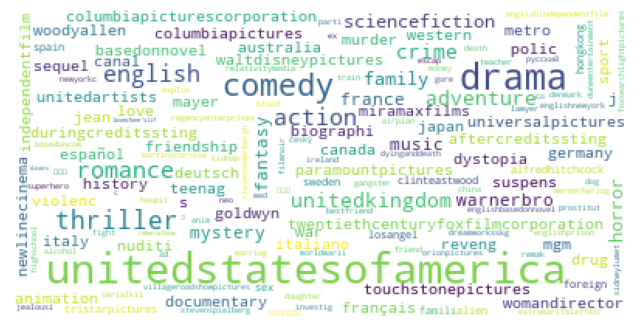

In [42]:
# Creating the Wordcloud for visualisation of the word which occur frequently in the dataset

# Combining all the text contained in smd['soup'] column
text = ""
for i in smd['soup']:
    text +=i
    
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
# plot the WordCloud image                      
plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
 
plt.show()

### Definitions of terms used in the below code

1. CountVectorizer is a tool provided by the scikit-learn library in Python.
2. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.
3. stop_words='english' is a built-in list, ngram_range is just a string of n words in a row.
4. Cosine similarity is a measure of similarity, often used to measure document similarity in text analysis.

In [63]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2) ,min_df=1, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])  # Creating a mapping between movie and title and index
indices.to_csv("ContentBasedRecommendationSystem/indices.csv")

In [64]:
df_cosine=pd.DataFrame(cosine_sim)
df_cosine.to_csv("ContentBasedRecommendationSystem/cosine_similarity.csv")
df_cosine

0         1         2         3         4         5         6     \
0     1.000000  0.080016  0.091502  0.089242  0.083351  0.045428  0.057789   
1     0.080016  1.000000  0.067267  0.065606  0.061276  0.044529  0.056644   
2     0.091502  0.067267  1.000000  0.125039  0.093428  0.067894  0.086367   
3     0.089242  0.065606  0.125039  1.000000  0.091121  0.066218  0.084234   
4     0.083351  0.061276  0.093428  0.091121  1.000000  0.046385  0.078674   
...        ...       ...       ...       ...       ...       ...       ...   
9214  0.053056  0.026003  0.029735  0.058001  0.027086  0.039367  0.025039   
9215  0.000000  0.000000  0.028760  0.028050  0.000000  0.019038  0.024218   
9216  0.000000  0.023020  0.026325  0.051350  0.000000  0.017426  0.022168   
9217  0.019623  0.038469  0.021995  0.042904  0.020036  0.043681  0.018522   
9218  0.068626  0.067267  0.076923  0.075023  0.070071  0.050921  0.043183   

          7         8         9     ...      9209      9210      9211  \
0     0.096589  0.063888  0.051594  ...  0.029788  0.054873  0.039246   
1     0.118345  0.083497  0.067430  ...  0.029198  0.053786  0.057703   
2     0.081200  0.071611  0.057831  ...  0.033389  0.061507  0.021995   
3     0.105593  0.069843  0.056403  ...  0.032564  0.079984  0.042904   
4     0.073967  0.065233  0.052680  ...  0.030415  0.056028  0.020036   
...        ...       ...       ...  ...       ...       ...       ...   
9214  0.062776  0.027682  0.022355  ...  0.000000  0.047552  0.051014   
9215  0.000000  0.026774  0.021622  ...  0.000000  0.022996  0.000000   
9216  0.083366  0.024507  0.019791  ...  0.000000  0.021049  0.067746   
9217  0.162527  0.081906  0.049609  ...  0.028642  0.035174  0.132075   
9218  0.081200  0.071611  0.096386  ...  0.066778  0.061507  0.021995   

          9212      9213      9214      9215      9216      9217      9218  
0     0.070457  0.071993  0.053056  0.000000  0.000000  0.019623  0.068626  
1     0.069061  0.052926  0.026003  0.000000  0.023020  0.038469  0.067267  
2     0.078975  0.080697  0.029735  0.028760  0.026325  0.021995  0.076923  
3     0.102699  0.078704  0.058001  0.028050  0.051350  0.042904  0.075023  
4     0.071940  0.073509  0.027086  0.000000  0.000000  0.020036  0.070071  
...        ...       ...       ...       ...       ...       ...       ...  
9214  0.061056  0.023395  1.000000  0.000000  0.030528  0.025507  0.029735  
9215  0.029527  0.000000  0.000000  1.000000  0.088581  0.000000  0.000000  
9216  0.027027  0.000000  0.030528  0.088581  1.000000  0.067746  0.000000  
9217  0.067746  0.069223  0.025507  0.000000  0.067746  1.000000  0.021995  
9218  0.078975  0.060523  0.029735  0.000000  0.000000  0.021995  1.000000  

[9219 rows x 9219 columns]

In [45]:
smd['original_title']

0                                               Toy Story
1                                                 Jumanji
2                                        Grumpier Old Men
3                                       Waiting to Exhale
4                             Father of the Bride Part II
                              ...                        
9214                       The Last Brickmaker in America
9215                                               रुस्तम
9216                                         Mohenjo Daro
9217                                               シン・ゴジラ
9218    The Beatles: Eight Days a Week - The Touring Y...
Name: original_title, Length: 9219, dtype: object

<Axes: >

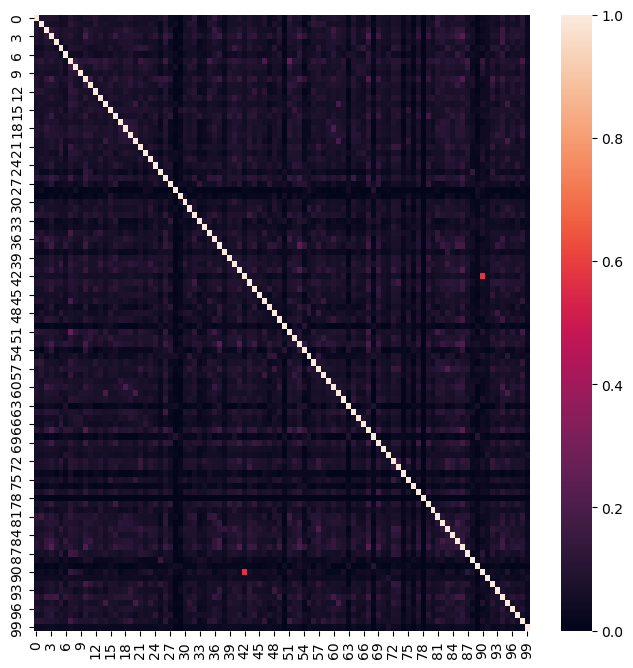

In [46]:
# Creating Heatmap for visualization of correlation between different movies 

#specify size of heatmap
fig, ax = plt.subplots(figsize=(8, 8))

#create seaborn heatmap of only top 100 movies
sns.heatmap(cosine_sim[:100,:100])

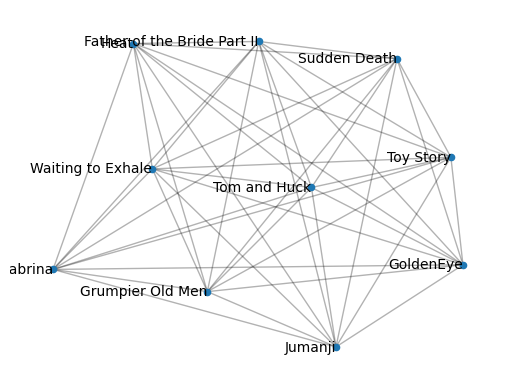

In [47]:
# Graph structure to visualize similarity relation between selected movies

g = nx.Graph()
n = 10

for i in range(n):
    g.add_node(titles[i])

for i in range(n):
    for j in range(n):
        if i != j and cosine_sim[i][j]>0:
            g.add_edge(titles[i],titles[j],weight = cosine_sim[i][j])
    
g = g.to_undirected()
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size = 20)
nx.draw_networkx_edges(g, pos,alpha = 0.3)
nx.draw_networkx_labels(g, pos, font_size=10, horizontalalignment="right")

plt.axis("off")
plt.show()

In [48]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9214
Rustom                                                9215
Mohenjo Daro                                          9216
Shin Godzilla                                         9217
The Beatles: Eight Days a Week - The Touring Years    9218
Length: 9219, dtype: int64

In [61]:
# movie_indices = []
def get_recommendations(title):
    
    '''
    
    This function gives the top 10 movies according to the cosine similarities calculated above along with the movie id
    
    Parameters: title (string) : Name of the movie present in the smd dataset
    
    Returns: (list) Top 10 movies along with the movie id
    
    
    '''
    
    idx = indices[title] # movie id corrosponding to the given title 
    sim_scores = list(enumerate(cosine_sim[idx])) # list of cosine similarity scores value along the given index
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # sorting the given scores in ascending order
    sim_scores = sim_scores[1:51] # Taking only the top 30 scores
    movie_indices = [i[0] for i in sim_scores] # Finding the indices of 30 most similar movies
#     print(movie_indices)
#     return titles.iloc[movie_indices] 
    return smd.iloc[movie_indices] 

get_recommendations('Death Becomes Her')
# movie_indices

index  adult                              belongs_to_collection  \
3990   5035  False                                                NaN   
2414   2898  False                                                NaN   
5689   8321  False                                                NaN   
3052   3703  False                                                NaN   
1590   1922  False  {'id': 264, 'name': 'Back to the Future Collec...   
7455  14566  False                                                NaN   
321     351  False                                                NaN   
8256  19920  False                                                NaN   
9031  31692  False                                                NaN   
3239   3924  False                                                NaN   
1591   1923  False  {'id': 264, 'name': 'Back to the Future Collec...   
6892  12295  False                                                NaN   
1274   1532  False                                                NaN   
1041   1246  False  {'id': 264, 'name': 'Back to the Future Collec...   
1933   2313  False  {'id': 89264, 'name': 'Romancing the Stone Col...   
3635   4497  False                                                NaN   
2504   3006  False                                                NaN   
656     775  False  {'id': 86028, 'name': 'The Nutty Professor Col...   
3617   4471  False                                                NaN   
4876   6736  False                                                NaN   
8663  23588  False                                                NaN   
1042   1247  False                                                NaN   
3070   3725  False  {'id': 86028, 'name': 'The Nutty Professor Col...   
7294  13830  False                                                NaN   
2640   3177  False                                                NaN   
4083   5206  False  {'id': 261526, 'name': 'Slap Shot Collection',...   
2235   2682  False                                                NaN   
4052   5154  False  {'id': 87220, 'name': 'Smokey and the Bandit C...   
1450   1766  False                                                NaN   
3240   3925  False                                                NaN   
3804   4745  False  {'id': 33071, 'name': 'Cheech & Chong Collecti...   
5525   7959  False                                                NaN   
8109  18983  False  {'id': 2806, 'name': 'American Pie Collection'...   
1593   1925  False                                                NaN   
3593   4436  False                                                NaN   
4028   5121  False  {'id': 221308, 'name': 'Oh, God! Collection', ...   
5034   7002  False                                                NaN   
6563  11293  False                                                NaN   
1814   2179  False                                                NaN   
2260   2711  False  {'id': 180854, 'name': 'Problem Child Collecti...   
3594   4437  False                                                NaN   
4051   5153  False  {'id': 87220, 'name': 'Smokey and the Bandit C...   
5895   9019  False                                                NaN   
5981   9463  False  {'id': 430186, 'name': 'Bring It On Collection...   
4656   6297  False  {'id': 124949, 'name': 'Almighty Collection', ...   
1975   2357  False                                                NaN   
3040   3689  False                                                NaN   
7936  17789  False                                                NaN   
387     433  False                                                NaN   
778     934  False                                                NaN   

         budget                                       genres  \
3990    8000000                             [action, comedy]   
2414   70000000  [fantasy, animation, comedy, crime, family]   
5689  165000000      [adventure, animation, family, fantasy]   
3052  100000000           

In [54]:
cosine_sim

array([[1.        , 0.080016  , 0.0915018 , ..., 0.        , 0.01962294,
        0.06862635],
       [0.080016  , 1.        , 0.06726728, ..., 0.02302046, 0.03846865,
        0.06726728],
       [0.0915018 , 0.06726728, 1.        , ..., 0.02632491, 0.02199529,
        0.07692308],
       ...,
       [0.        , 0.02302046, 0.02632491, ..., 1.        , 0.06774581,
        0.        ],
       [0.01962294, 0.03846865, 0.02199529, ..., 0.06774581, 1.        ,
        0.02199529],
       [0.06862635, 0.06726728, 0.07692308, ..., 0.        , 0.02199529,
        1.        ]])

## Collabrative Filtering

Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not. We will be using Surprise library which uses algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and other metrics and give great recommendations.

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. It is taking as input ratings of few movies done by a set of users and predicting the rating of remaining movies by using collaborative filtering algorithm ( in this we are using SVD algorithm ).

SVD creates a lower dimensional representation for each user and movie based on some latent factors(featurs of movies) and based on these lower dimensional representation model predicts rating of user for other movie. The dimension of latent factor can be controlled by n_factor parameter of a model ( its default value is 100 ). Usually, the quality of the training set predictions grows with as n_factors gets higher.

Steps involved:

1. Preprocessing of data ( removing irrelevant columns, checking NAN values etc )
2. Using surprise library to make train and test dataset
3. Trained the model on the available data ( training dataset )
4. Finally, tested the quality of model by using RMSE and MAE
5. Now that our model is fitted, we can call predict to get some predictions. predict returns an internal object Prediction which can be easily converted back to a dataframe.

Mean Absolute Error (MAE) measures the average magnitude of the errors in a set of predictions, without considering their direction. Root mean squared error (RMSE) is the square root of the average of squared differences between prediction and actual observation. Lower value of both RMSE and MAE is considered to be good.

In [65]:
# drop the timestamp column since we dont need it now
ratings = ratings.drop(columns="timestamp")

#checking for missing values
ratings.isna().sum()

#check for the numbers of total movies and users
movies= ratings['movieId'].nunique()  #nunique is similar to count but only takes unique values
users=ratings['userId'].nunique()
print('total number of movies =', movies)
print('total number of users =', users)

#  HIstogram showing frequency of ratings given by different users
fig = px.histogram(ratings, x="rating")
fig.show()

total number of movies = 9066
total number of users = 671


In [66]:
# columns to use for training
columns = ['userId','movieId','rating']

# create reader from surprise 
# the rating should lie in the provided scale
reader = Reader(rating_scale =(0.5,5))

#create dataset from dataframe
data = Dataset.load_from_df(ratings[columns],reader)

# create trainset ie the data which is present (ratings of those movies which are rated by respective users)
trainset = data.build_full_trainset()

# create testset, here the anti_testset is testset
# data containing users movie pairs which are not rated by that particular user
testset = trainset.build_anti_testset()
 

model = SVD(n_epochs = 25, verbose = True) #n_epochs:The number of iteration of the SGD(simple gradient descent) procedure. Default is 20
                                           #verbose:If True, prints the current epoch. Default is False.
    
cross_validate(model, data, measures=['RMSE','MAE'], cv= 5, verbose= True)
print('Training Done')

#prediction
prediction = model.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

Using user rating of selected movies to get suitable recommendations
1. To incorporate the user in the system we inspected the dataset and found that mostly users have around 5-10 ratings.
2. To get recommendation according to taste of user we prompt the user to rate the selected movies.
3. We add those selection to our standerd dataset and run the collaborative filtering algorithm to get the ratings of other movies.
4. Finally, recommending top 10 movies based on highest ratings.

In [68]:
example = { 'userId' : [99999,99999,99999,99999,99999],
           'movieId' : [31,1029,1293,1172,1343],
           'rating'  : [3.0, 4.5, 1.2, 3.3,2]
    
}

df = pd.DataFrame(example)
frames = [ratings, df]
result = pd.concat(frames)
result

userId  movieId  rating
0        1       31     2.5
1        1     1029     3.0
2        1     1061     3.0
3        1     1129     2.0
4        1     1172     4.0
..     ...      ...     ...
0    99999       31     3.0
1    99999     1029     4.5
2    99999     1293     1.2
3    99999     1172     3.3
4    99999     1343     2.0

[100009 rows x 3 columns]

In [69]:
#create dataset from dataframe
data= Dataset.load_from_df(result[columns],reader)

#create trainset
trainset= data.build_full_trainset()

#create testset, here the anti_testset is testset
testset = trainset.build_anti_testset()

cross_validate(model,data, measures=['RMSE','MAE'], cv= 5, verbose= True) #cv is the number of parts in which data will be divided.
print('Training Done')

#prediction
prediction = model.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

In [70]:
prediction

[Prediction(uid=1, iid=10, r_ui=3.5435710786029255, est=2.6316461822848716, details={'was_impossible': False}),
 Prediction(uid=1, iid=17, r_ui=3.5435710786029255, est=3.1985300553379874, details={'was_impossible': False}),
 Prediction(uid=1, iid=39, r_ui=3.5435710786029255, est=2.924213569861061, details={'was_impossible': False}),
 Prediction(uid=1, iid=47, r_ui=3.5435710786029255, est=3.5510954078775505, details={'was_impossible': False}),
 Prediction(uid=1, iid=50, r_ui=3.5435710786029255, est=4.002081620942023, details={'was_impossible': False}),
 Prediction(uid=1, iid=52, r_ui=3.5435710786029255, est=2.821477763686805, details={'was_impossible': False}),
 Prediction(uid=1, iid=62, r_ui=3.5435710786029255, est=3.174966949922447, details={'was_impossible': False}),
 Prediction(uid=1, iid=110, r_ui=3.5435710786029255, est=3.6814853478699656, details={'was_impossible': False}),
 Prediction(uid=1, iid=144, r_ui=3.5435710786029255, est=2.6197688342497556, details={'was_impossible': Fal

In [71]:
def get_top_n(prediction, n):
    
    '''
    This function recommend users with top n movies based on prediction calculated using the surprise library
    
    Parameters: prediction(list): This contains (user, movie) rating prediction for all user movie pairs
                n(int): Number of recommendations
    
    Results: Returns top 30 movies along with movie id for all users
    
    
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in prediction: 
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
#         if uid==1:
#             print(user_ratings)
        top_n[uid] = user_ratings[:n]

    return top_n

rcmnd = []
top_n = get_top_n(prediction, n=30)


for uid, user_ratings in top_n.items():
    if uid == 99999:
        for (iid,rating) in user_ratings:
            for i in range(movies_data.shape[0]):
                if movies_data['id'][i] == iid:
                    rcmnd.append([movies_data['id'][i],movies_data['title'][i]])
        break

In [72]:
top_n

defaultdict(list,
            {1: [(50, 4.002081620942023),
              (3088, 3.8203089469752474),
              (527, 3.8060689038359636),
              (1197, 3.7700699833130606),
              (260, 3.764162869550442),
              (778, 3.752102771283277),
              (926, 3.7518745168715926),
              (1209, 3.737414092351364),
              (858, 3.7359269374011626),
              (593, 3.7319793433293493),
              (908, 3.7105147290223504),
              (318, 3.702845096277264),
              (246, 3.70264706467291),
              (2501, 3.702030348088076),
              (1221, 3.6985977681089346),
              (1361, 3.691481524443709),
              (898, 3.689960851848383),
              (3462, 3.6818168405098612),
              (110, 3.6814853478699656),
              (69844, 3.681117386290014),
              (2858, 3.6801952036912144),
              (106920, 3.6777965321233728),
              (1252, 3.67746386313556),
              (1233, 3.6712575142523

In [218]:
rcmnd

[[858, 'Sleepless in Seattle'],
 [1260, 'Lotte from Gadgetville'],
 [111, 'Scarface'],
 [3022, 'Dr. Jekyll and Mr. Hyde'],
 [1945, 'Nell'],
 [318, 'The Million Dollar Hotel'],
 [950, 'Ice Age: The Meltdown'],
 [608, 'Men in Black II'],
 [1948, 'Crank'],
 [911, 'The Bank Dick'],
 [2692, 'The Red Elvis'],
 [501, 'Grizzly Man']]